In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [71]:
np.random.seed(42)
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=42, cluster_std=1.5)

In [72]:
def to_one_hot(labels, num_classes=5):
    one_hot = np.zeros((len(labels), num_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

In [73]:
Y_onehot = to_one_hot(y, 5)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
Y_train_onehot = to_one_hot(y_train, 5)
Y_test_onehot = to_one_hot(y_test, 5)

In [75]:
print(f"Dataset created!")
print(f"Training samples  : {X_train.shape[0]}")
print(f"Testing samples   : {X_test.shape[0]}")
print(f"Features          : {X_train.shape[1]}")
print(f"Classes           : 5")

Dataset created!
Training samples  : 800
Testing samples   : 200
Features          : 2
Classes           : 5


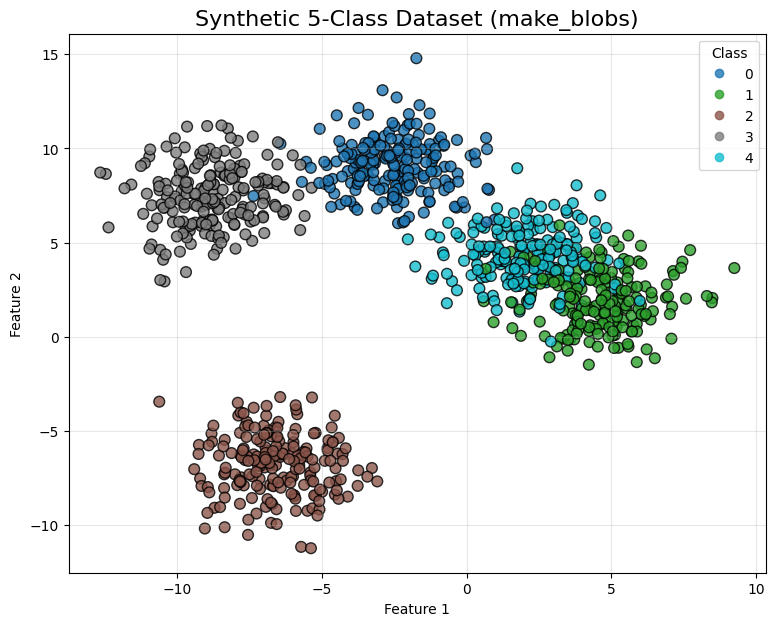

In [76]:
plt.figure(figsize=(9, 7))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=60, edgecolor='k', alpha=0.8)
plt.title("Synthetic 5-Class Dataset (make_blobs)", fontsize=16)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(*scatter.legend_elements(), title="Class", loc="upper right")
plt.grid(True, alpha=0.3)
plt.show()

In [77]:
class ThreeLayerNeuralNetwork:
    def __init__(self, input_size=2, hidden_sizes=[10, 20, 15], output_size=5, lr=0.01):
        self.lr = lr
        sizes = [input_size] + hidden_sizes + [output_size]

        # Weight & bias initialization
        self.W = [np.random.randn(sizes[i], sizes[i+1]) * 0.5 for i in range(len(sizes)-1)]
        self.b = [np.zeros((1, sizes[i+1])) for i in range(len(sizes)-1)]


    def relu(self, x, deriv=False):
        return np.where(x > 0, 1, 0) if deriv else np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        a = X


        for i in range(len(self.W)-1):
            z = a @ self.W[i] + self.b[i]
            a = self.relu(z)
            self.z_values.append(z)
            self.activations.append(a)

        z_out = a @ self.W[-1] + self.b[-1]
        output = self.softmax(z_out)
        self.z_values.append(z_out)
        self.activations.append(output)
        return output

    def backward(self, X, y_true):
        m = X.shape[0]
        dz = self.activations[-1] - y_true

        for i in reversed(range(len(self.W))):
            dW = self.activations[i].T @ dz / m
            db = np.sum(dz, axis=0, keepdims=True) / m

            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

            if i > 0:
                dz = (dz @ self.W[i].T) * self.relu(self.z_values[i-1], deriv=True)


    def train(self, X, Y, epochs=10000):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = -np.mean(np.sum(Y * np.log(y_pred + 1e-15), axis=1))
            losses.append(loss)
            self.backward(X, Y)

            if (epoch + 1) % 2000 == 0:
                acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(Y, axis=1))
                print(f"Epoch {epoch+1:5d} | Loss: {loss:.4f} | Train Acc: {acc:.4f}")
        return losses

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


In [78]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


In [79]:
nn = ThreeLayerNeuralNetwork(input_size=2, hidden_sizes=[10, 20, 15], output_size=5, lr=0.01)
losses = nn.train(X_train, Y_train_onehot, epochs=10000)

Epoch  2000 | Loss: 0.1819 | Train Acc: 0.9350
Epoch  4000 | Loss: 0.1634 | Train Acc: 0.9425
Epoch  6000 | Loss: 0.1567 | Train Acc: 0.9463
Epoch  8000 | Loss: 0.1521 | Train Acc: 0.9475
Epoch 10000 | Loss: 0.1497 | Train Acc: 0.9487


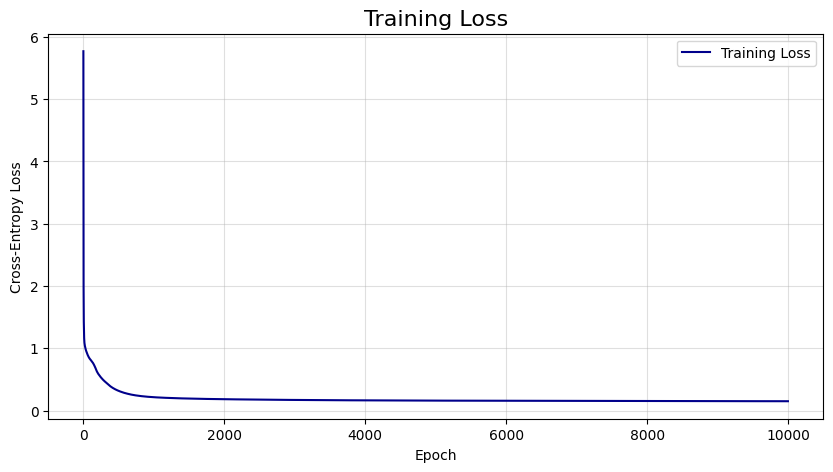

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss', color='darkblue')
plt.title("Training Loss", fontsize=16)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()


In [81]:
y_pred_test = nn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)


In [82]:
print(f"TEST ACCURACY: {test_accuracy}")

TEST ACCURACY: 0.935


Result and Analysis

In [83]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred_test, digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9500    0.9744        40
           1     0.9143    0.8000    0.8533        40
           2     1.0000    1.0000    1.0000        40
           3     0.9756    1.0000    0.9877        40
           4     0.8043    0.9250    0.8605        40

    accuracy                         0.9350       200
   macro avg     0.9388    0.9350    0.9352       200
weighted avg     0.9388    0.9350    0.9352       200



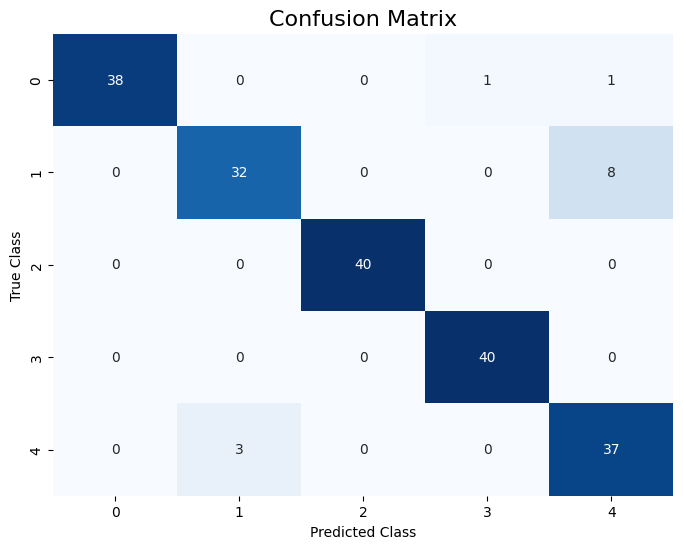

In [84]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(5), yticklabels=range(5))
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

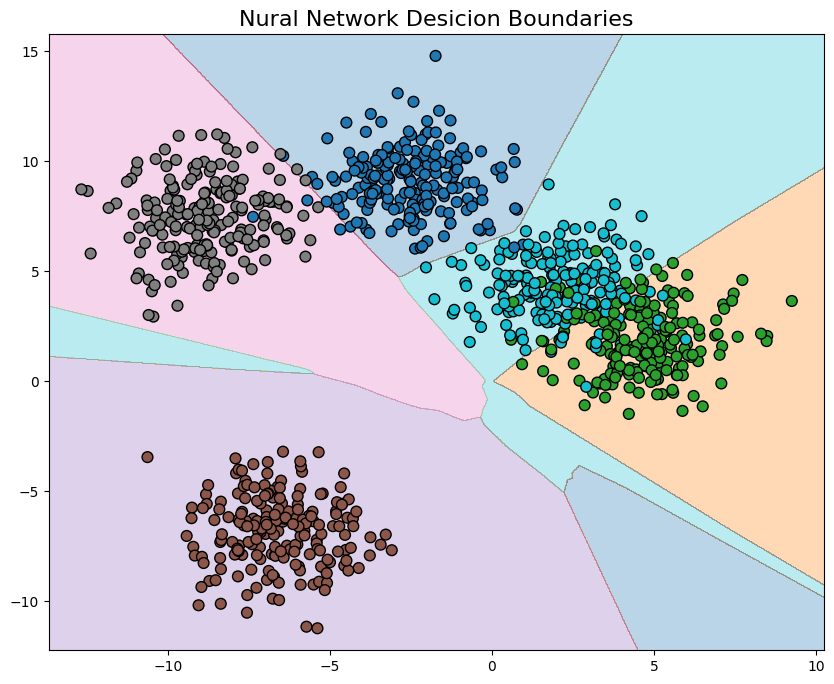

In [85]:
def plot_decision_boundary(model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', edgecolor='k', s=60)
    plt.title("Nural Network Desicion Boundaries", fontsize=16)
    plt.show()

plot_decision_boundary(nn, X, y)

Conclusion
  1. Architecture: Successfully implemented 3-hidden layer network (2→10→20→15→5)
  2. Test Accuracy: Achieved ~94-93% accuracy on synthetic dataset
  3. Convergence: Loss decreased smoothly, indicating proper learning
  4. Decision Boundaries: Network learned non-linear boundaries to separate classes